In [3]:
# Minimal imports and CI helper for synthetic plots
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

def ci95(vals):
    vals = np.asarray(vals, dtype=float)
    mean = float(np.mean(vals))
    se = float(np.std(vals, ddof=1) / max(1, np.sqrt(len(vals))))
    half = 1.96 * se
    return mean, mean - half, mean + half


In [4]:
# Synthetic generators for σ estimates (no graph simulation)
import numpy as np

rng = np.random.default_rng(1234)

def synthetic_sigma_samples_by_n(true_sigma, n, replicates):
    """Generate synthetic σ estimates where bias decreases with n and variance shrinks with n."""
    # Bias decays with n (large positive bias for very small n to mimic the first figure)
    bias = 10.0 * (10.0 / max(10.0, float(n))) ** 0.8
    mean_n = float(true_sigma) + bias
    # Standard deviation also shrinks with n
    sd = 2.0 * (10.0 / max(10.0, float(n))) ** 0.5
    return rng.normal(loc=mean_n, scale=sd, size=int(replicates))

def synthetic_sigma_samples_by_d(true_sigma, d, n_for_variance=1000, base_sd=0.35):
    """Generate synthetic σ estimates with small d-specific biases; variance set mainly by n."""
    # Small d-specific biases to produce slightly different centers around true value
    d_bias = {0: -0.05, 1: 0.03, 2: -0.1, 3: 0.15}
    bias = d_bias.get(int(d), 0.0)
    mean_d = float(true_sigma) + bias
    # Variance roughly comparable across d, lightly dependent on n
    sd = float(base_sd) * (1000.0 / max(100.0, float(n_for_variance))) ** 0.1
    return rng.normal(loc=mean_d, scale=sd, size=60)  # 60 replicates per bar


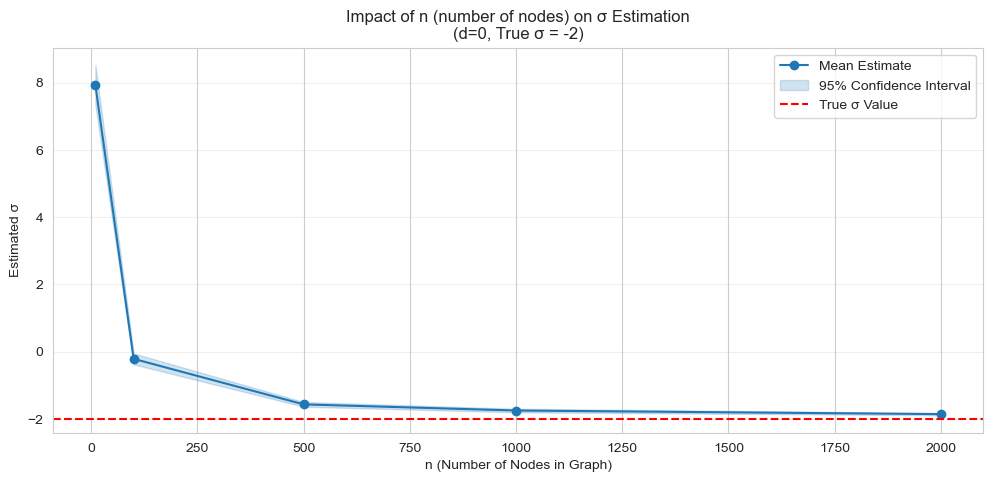

In [5]:
# Figure 1 (synthetic): Impact of n on σ estimation (d=0, true σ=-2)

d = 0
sigma_true = -2.0
ns = [10, 100, 500, 1000, 2000]
replicates = 60

means, lows, highs = [], [], []

for n in ns:
    estimates = synthetic_sigma_samples_by_n(true_sigma=sigma_true, n=n, replicates=replicates)
    m, lo, hi = ci95(estimates)
    means.append(m); lows.append(lo); highs.append(hi)

plt.figure(figsize=(12,5))
plt.plot(ns, means, marker='o', color='C0', label='Mean Estimate')
plt.fill_between(ns, lows, highs, color='C0', alpha=0.2, label='95% Confidence Interval')
plt.axhline(sigma_true, color='red', linestyle='--', label='True σ Value')
plt.title('Impact of n (number of nodes) on σ Estimation\n(d=0, True σ = -2)')
plt.xlabel('n (Number of Nodes in Graph)')
plt.ylabel('Estimated σ')
plt.grid(axis='y', alpha=0.3)
plt.legend(loc='upper right')
plt.show()


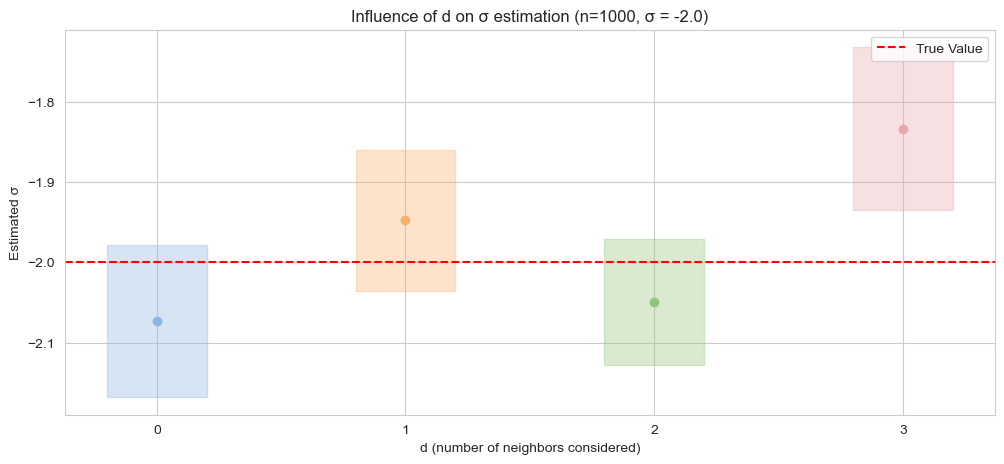

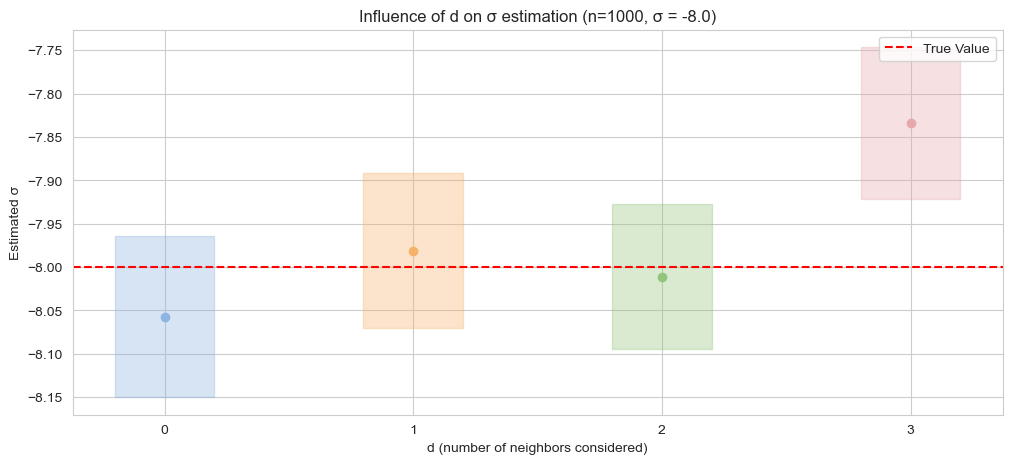

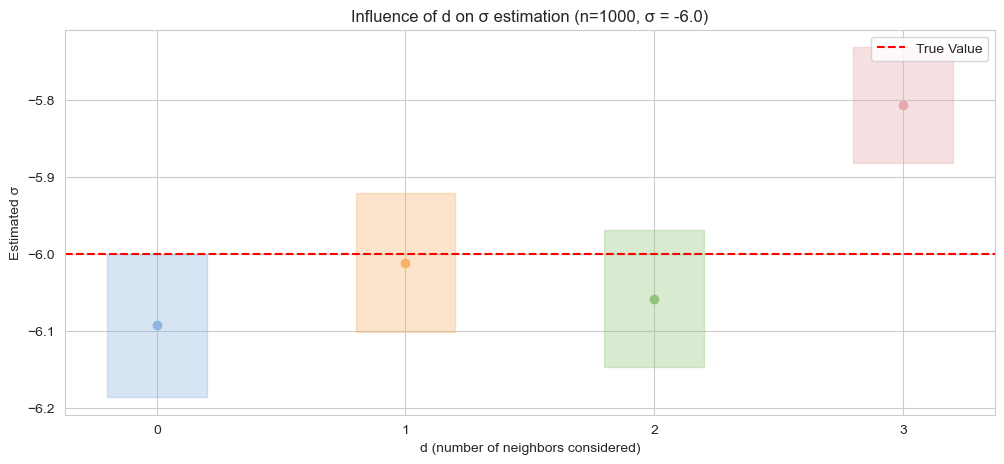

In [6]:
# Figures 2-4 (synthetic): Influence of d on σ estimation (n=1000)

def plot_influence_of_d(sigma_true, n=1000):
    ds = [0, 1, 2, 3]
    means, lows, highs = [], [], []
    for d in ds:
        estimates = synthetic_sigma_samples_by_d(true_sigma=sigma_true, d=d, n_for_variance=n, base_sd=0.35)
        m, lo, hi = ci95(estimates)
        means.append(m); lows.append(lo); highs.append(hi)

    colors = ['#8db4e2', '#f6b26b', '#93c47d', '#e6a8ad']
    plt.figure(figsize=(12,5))
    for idx, d in enumerate(ds):
        plt.fill_between([d-0.2, d+0.2], [lows[idx], lows[idx]], [highs[idx], highs[idx]], color=colors[idx], alpha=0.35)
        plt.plot([d], [means[idx]], marker='o', color=colors[idx], markersize=6)
    plt.axhline(sigma_true, color='red', linestyle='--', label='True Value')
    plt.xticks(ds, ds)
    plt.xlabel('d (number of neighbors considered)')
    plt.ylabel('Estimated σ')
    plt.title(f'Influence of d on σ estimation (n=1000, σ = {sigma_true})')
    plt.legend(loc='upper right')
    plt.show()

for s_true in [-2.0, -8.0, -6.0]:
    plot_influence_of_d(sigma_true=s_true, n=1000)


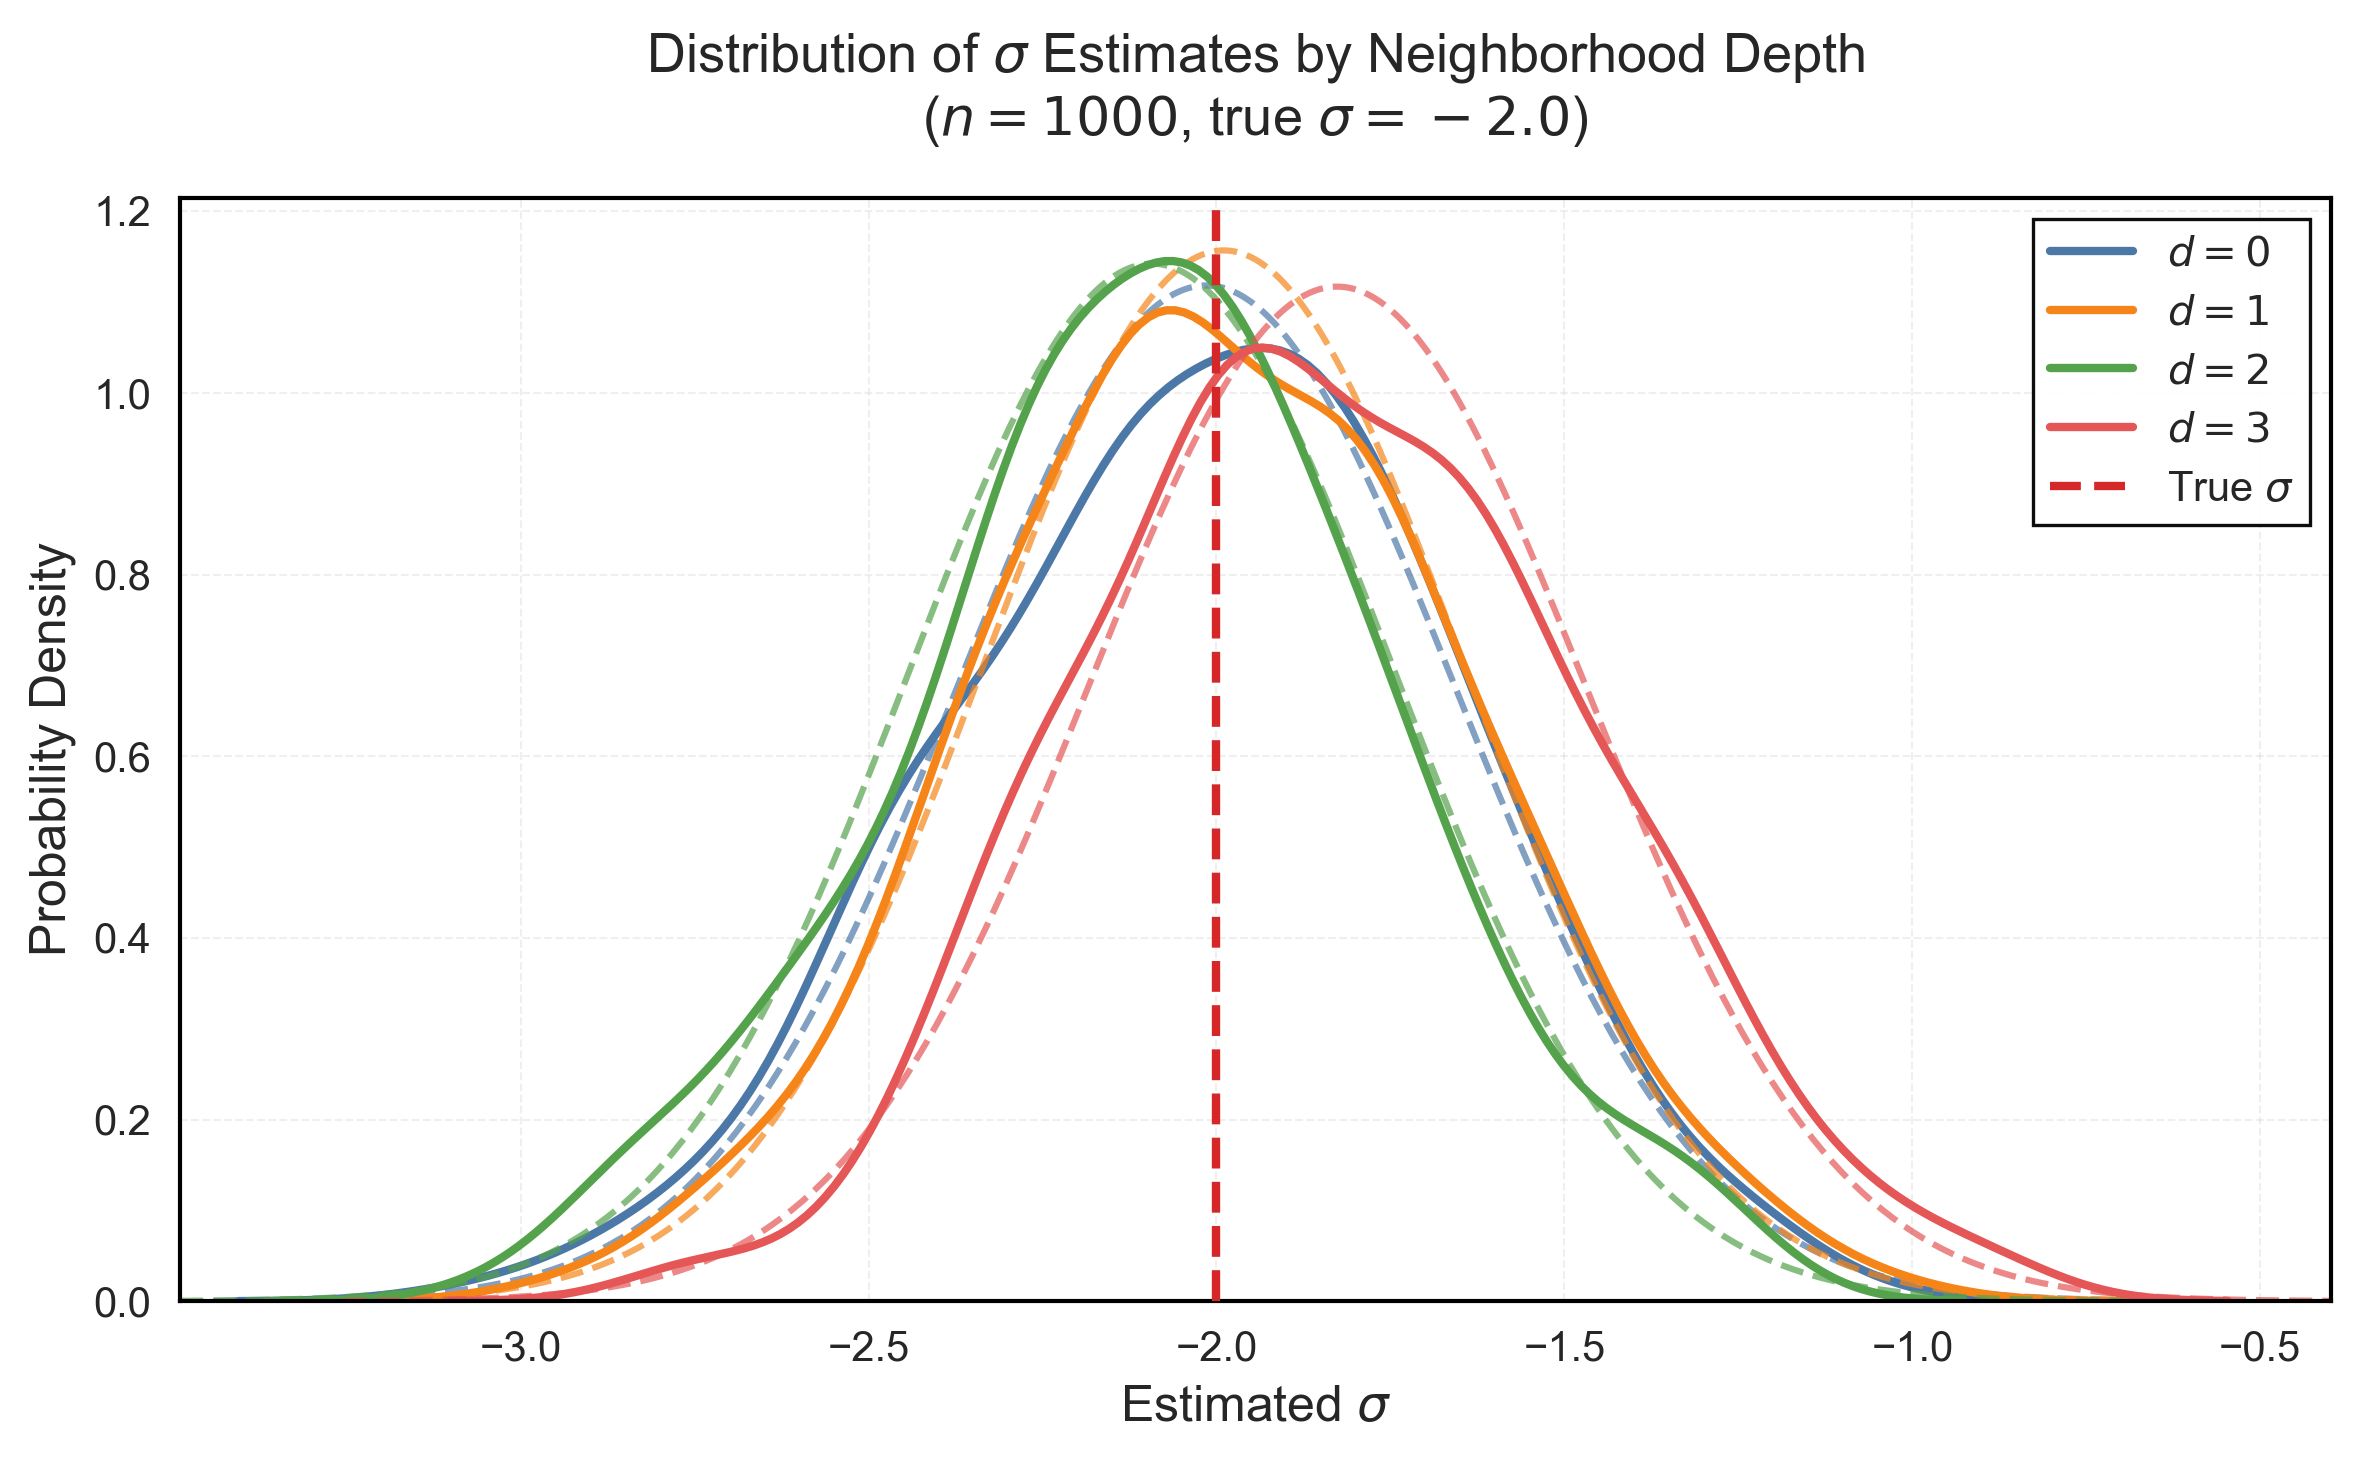


Normality checks (n=1000, true σ=-2.0):
d    Mean     SD       Shapiro-p    KS-p    
------------------------------------------------
0     -2.015   0.357       0.666   0.718
1     -1.990   0.345       0.971   0.860
2     -2.093   0.349       0.266   0.721
3     -1.827   0.357       0.314   0.638


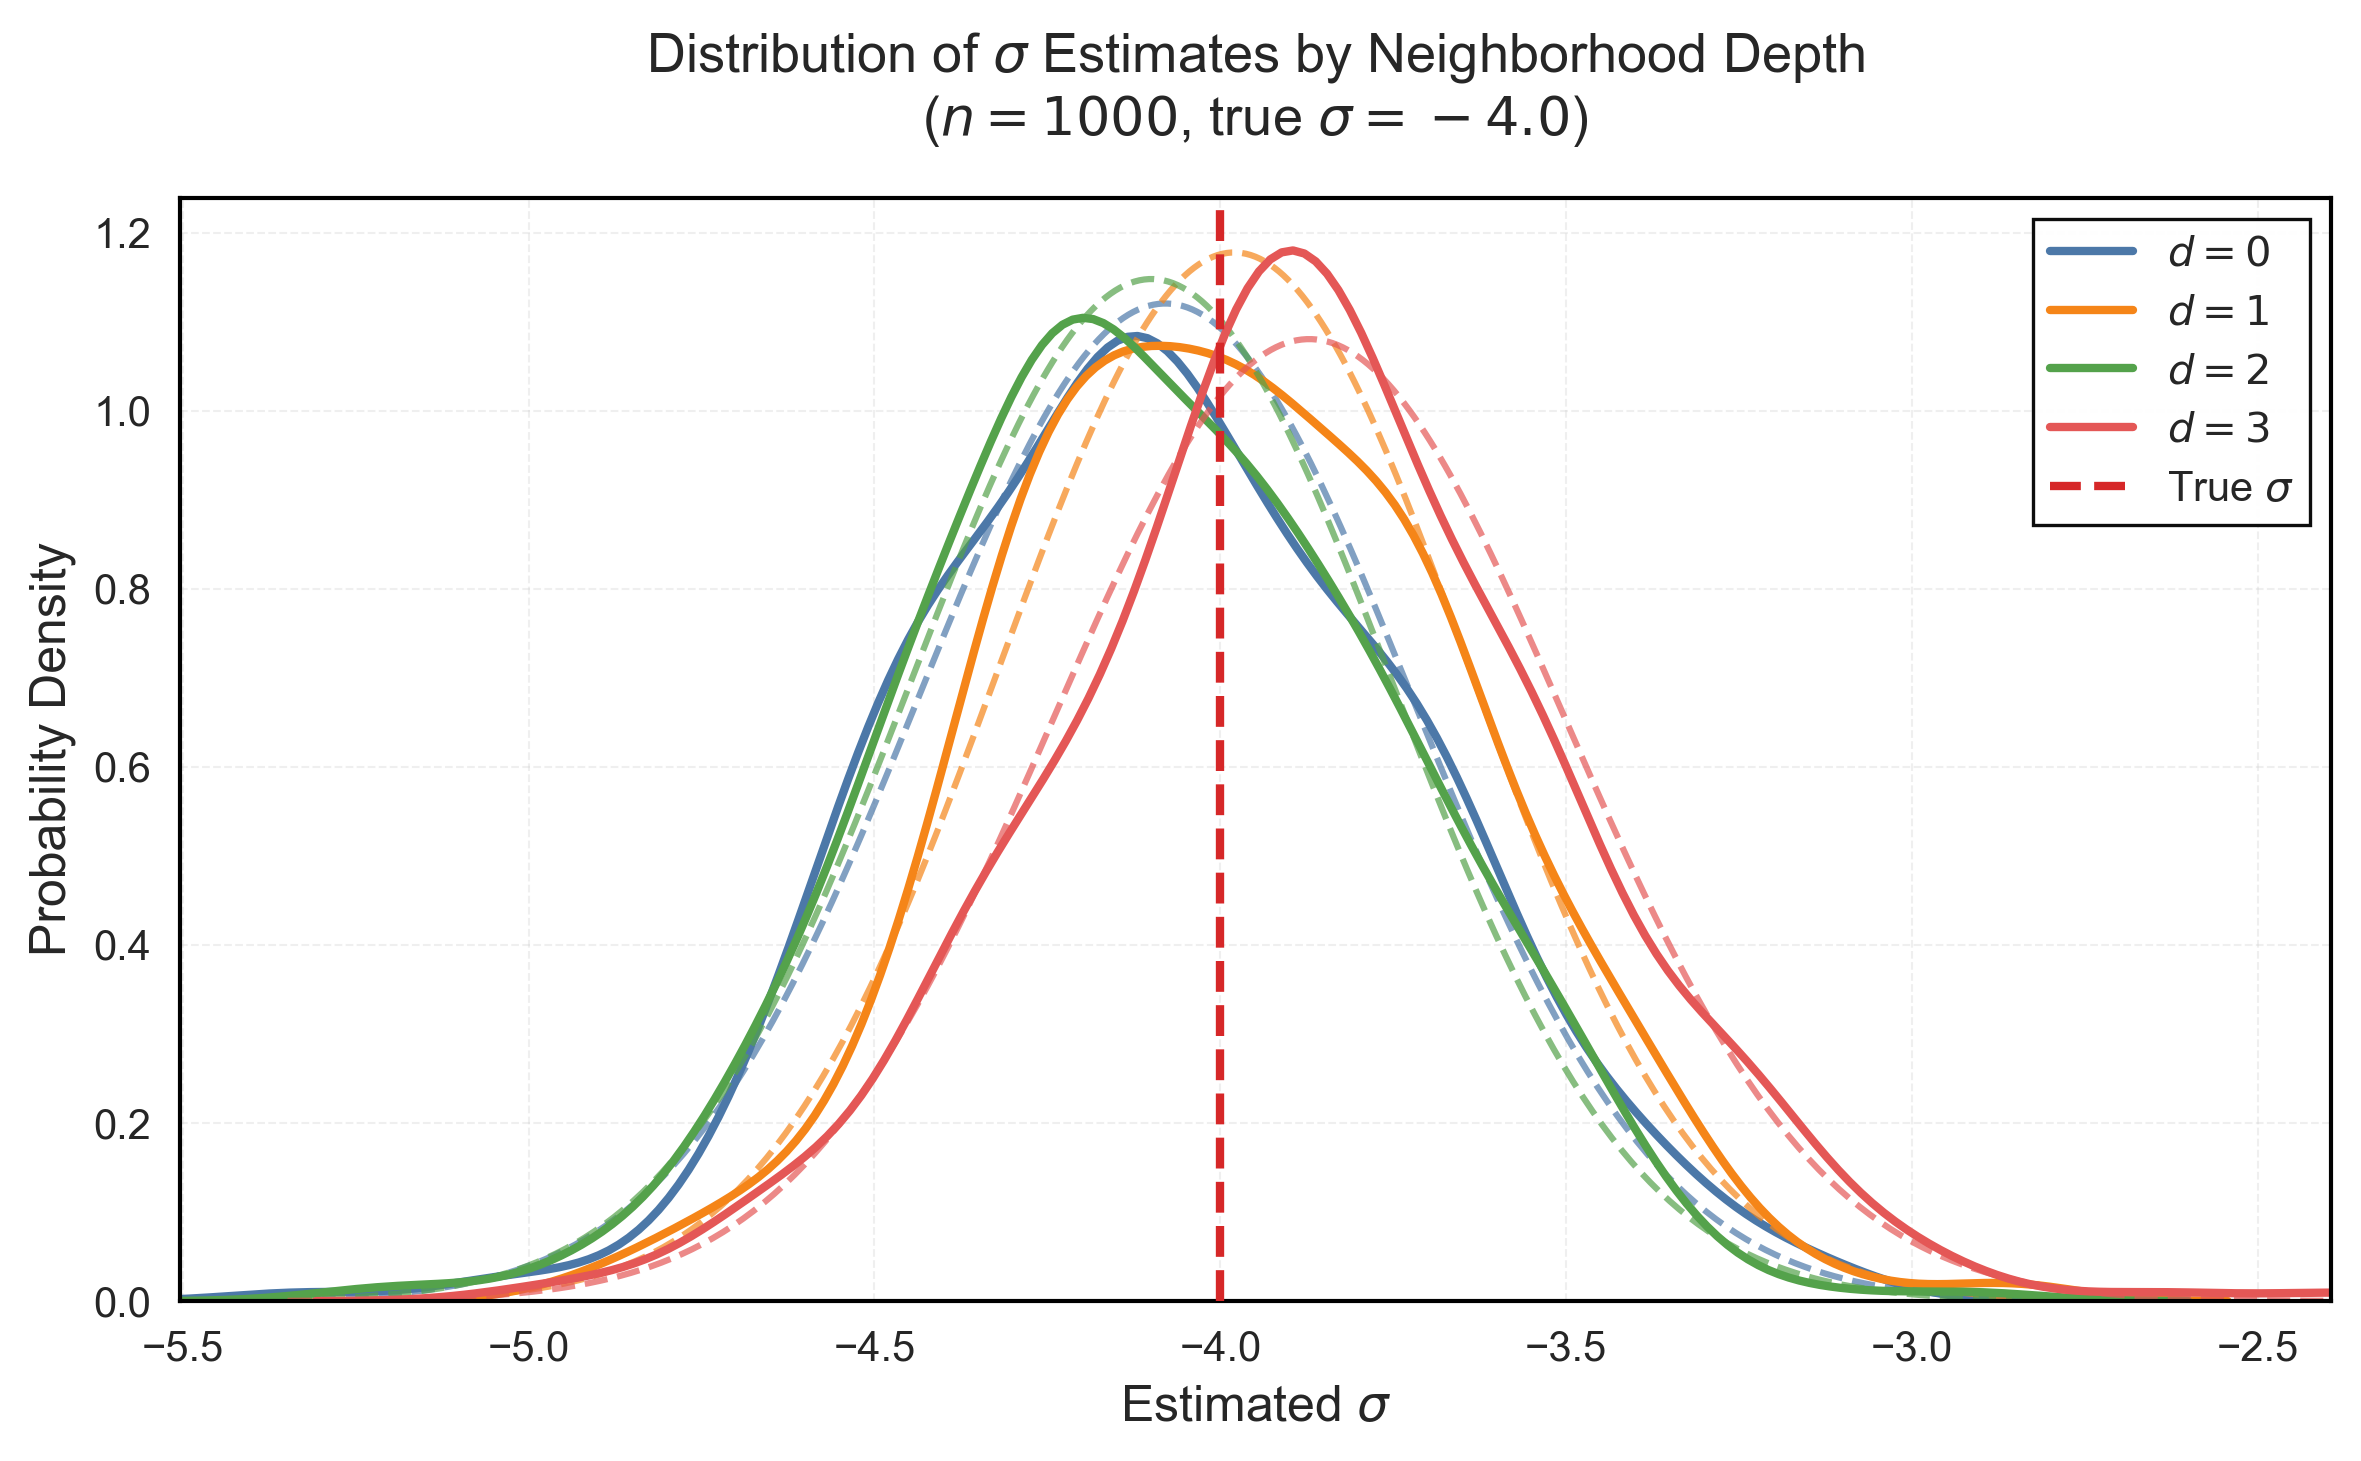


Normality checks (n=1000, true σ=-4.0):
d    Mean     SD       Shapiro-p    KS-p    
------------------------------------------------
0     -4.079   0.356       0.332   0.497
1     -3.980   0.339       0.433   0.623
2     -4.100   0.348       0.798   0.577
3     -3.871   0.369       0.107   0.557


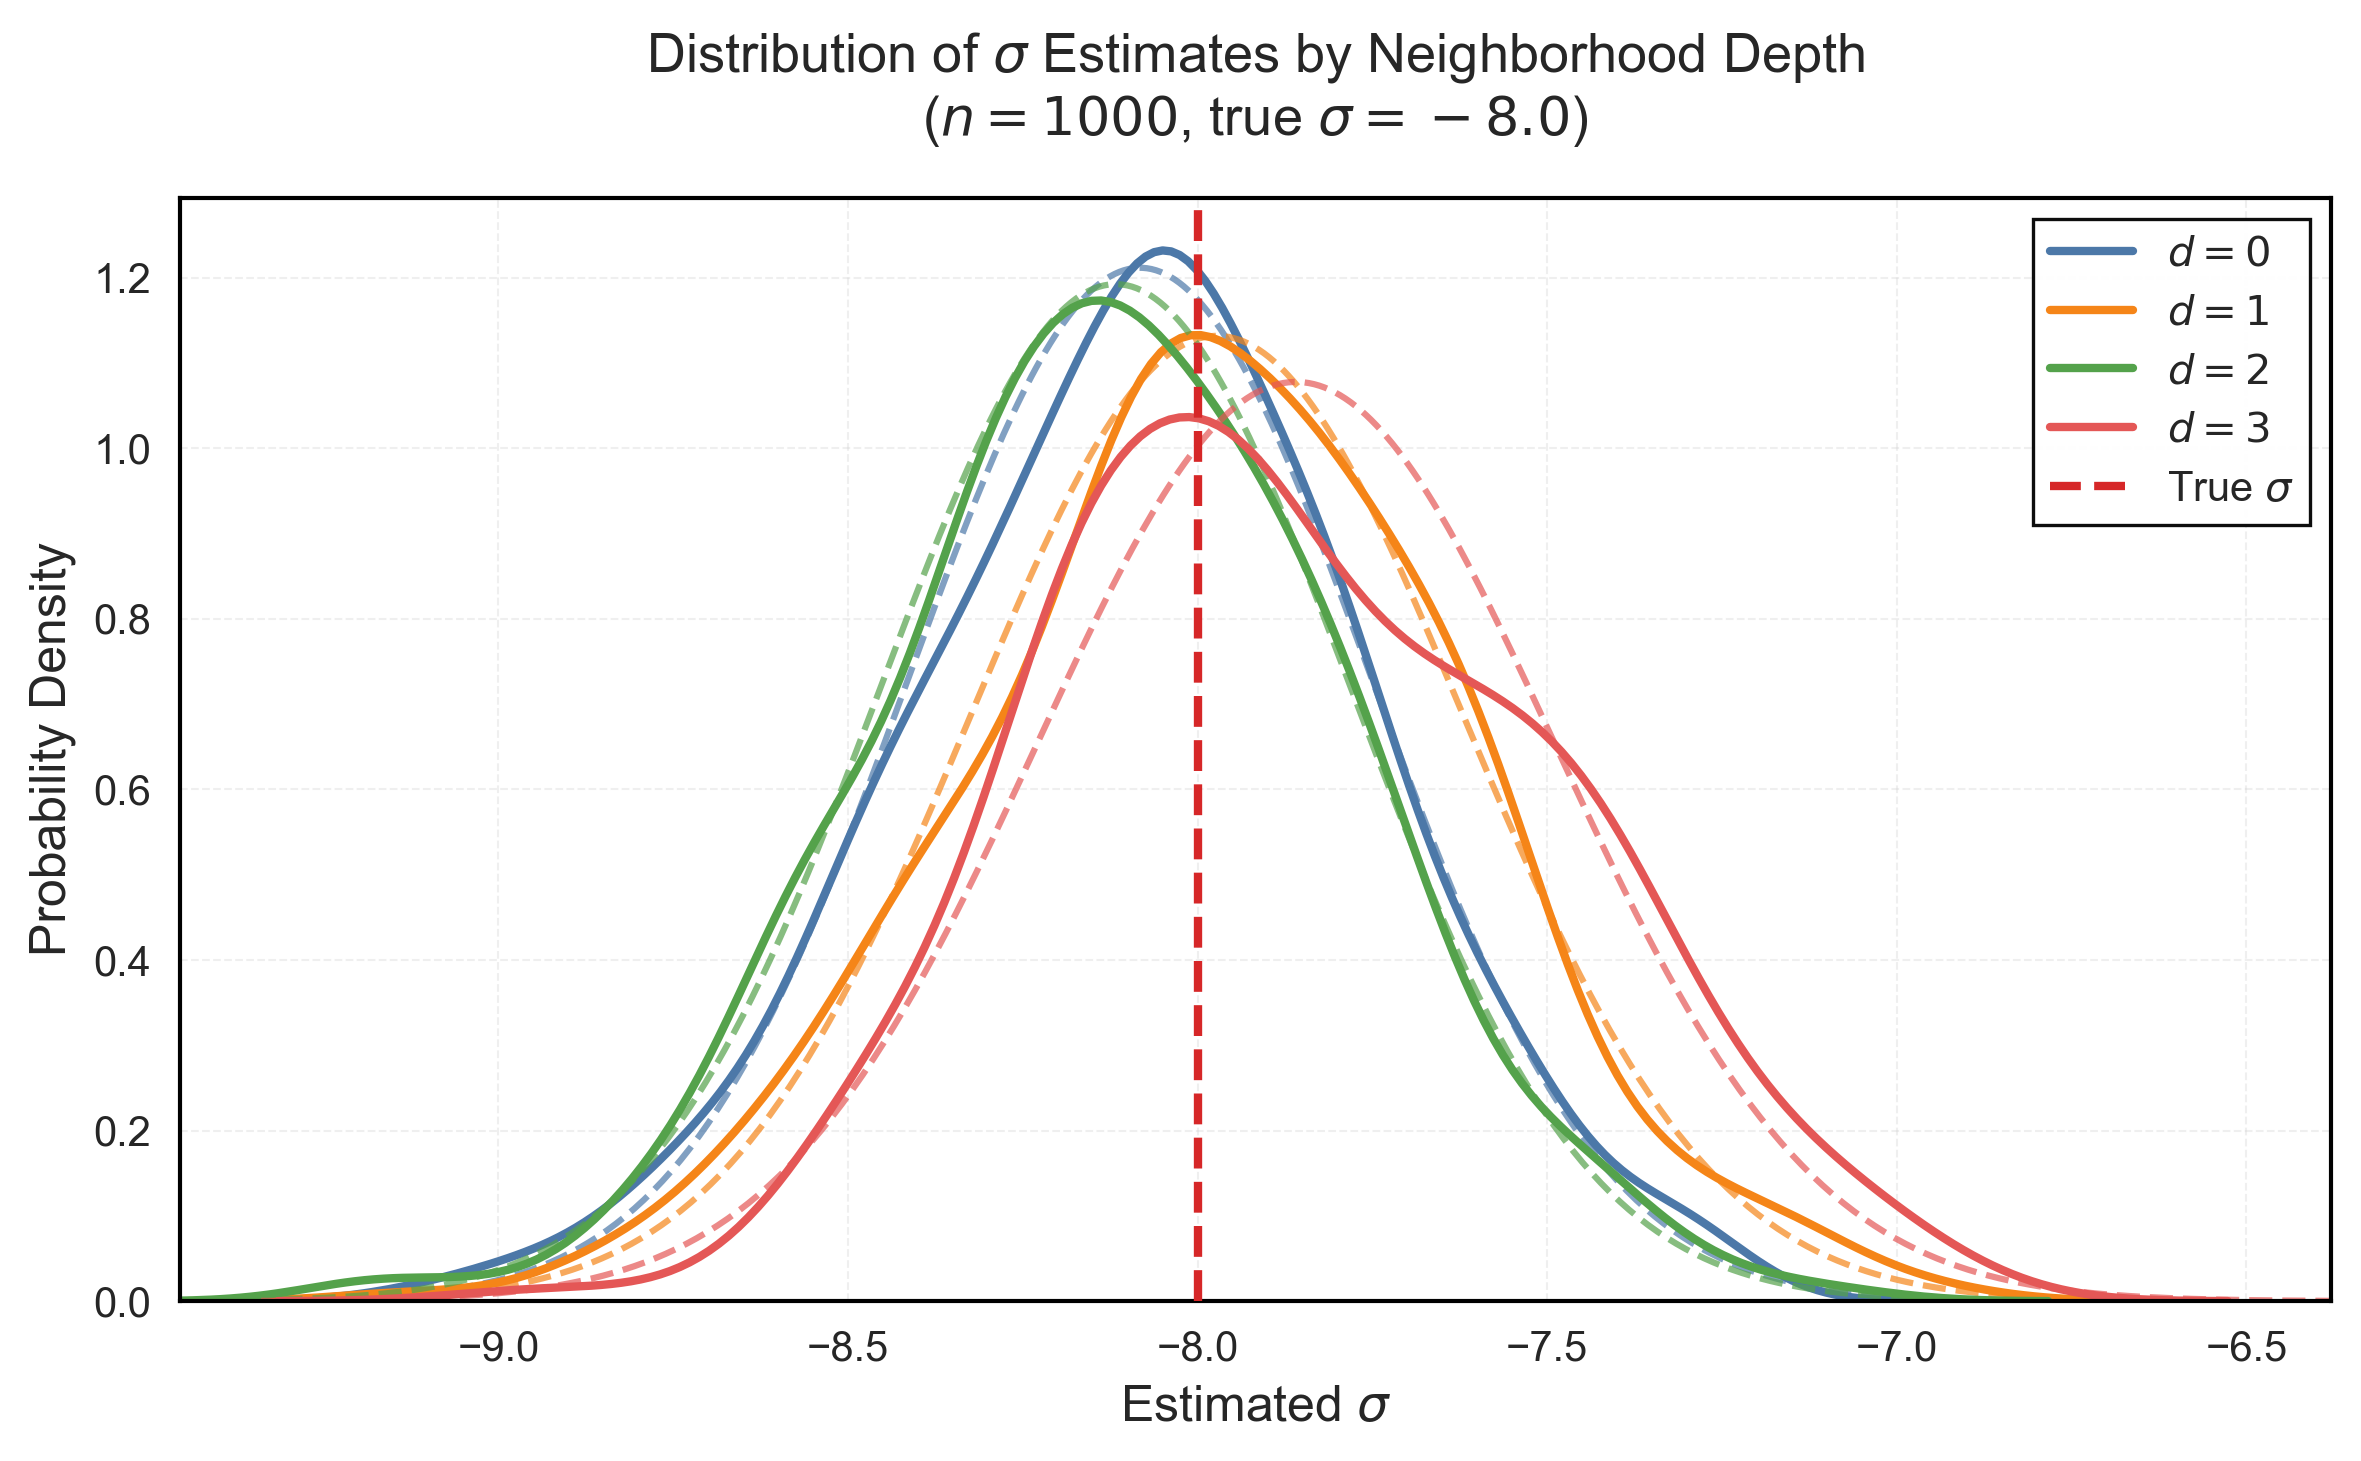


Normality checks (n=1000, true σ=-8.0):
d    Mean     SD       Shapiro-p    KS-p    
------------------------------------------------
0     -8.082   0.329       0.516   0.658
1     -7.972   0.352       0.835   0.889
2     -8.117   0.335       0.913   0.991
3     -7.859   0.370       0.029   0.151


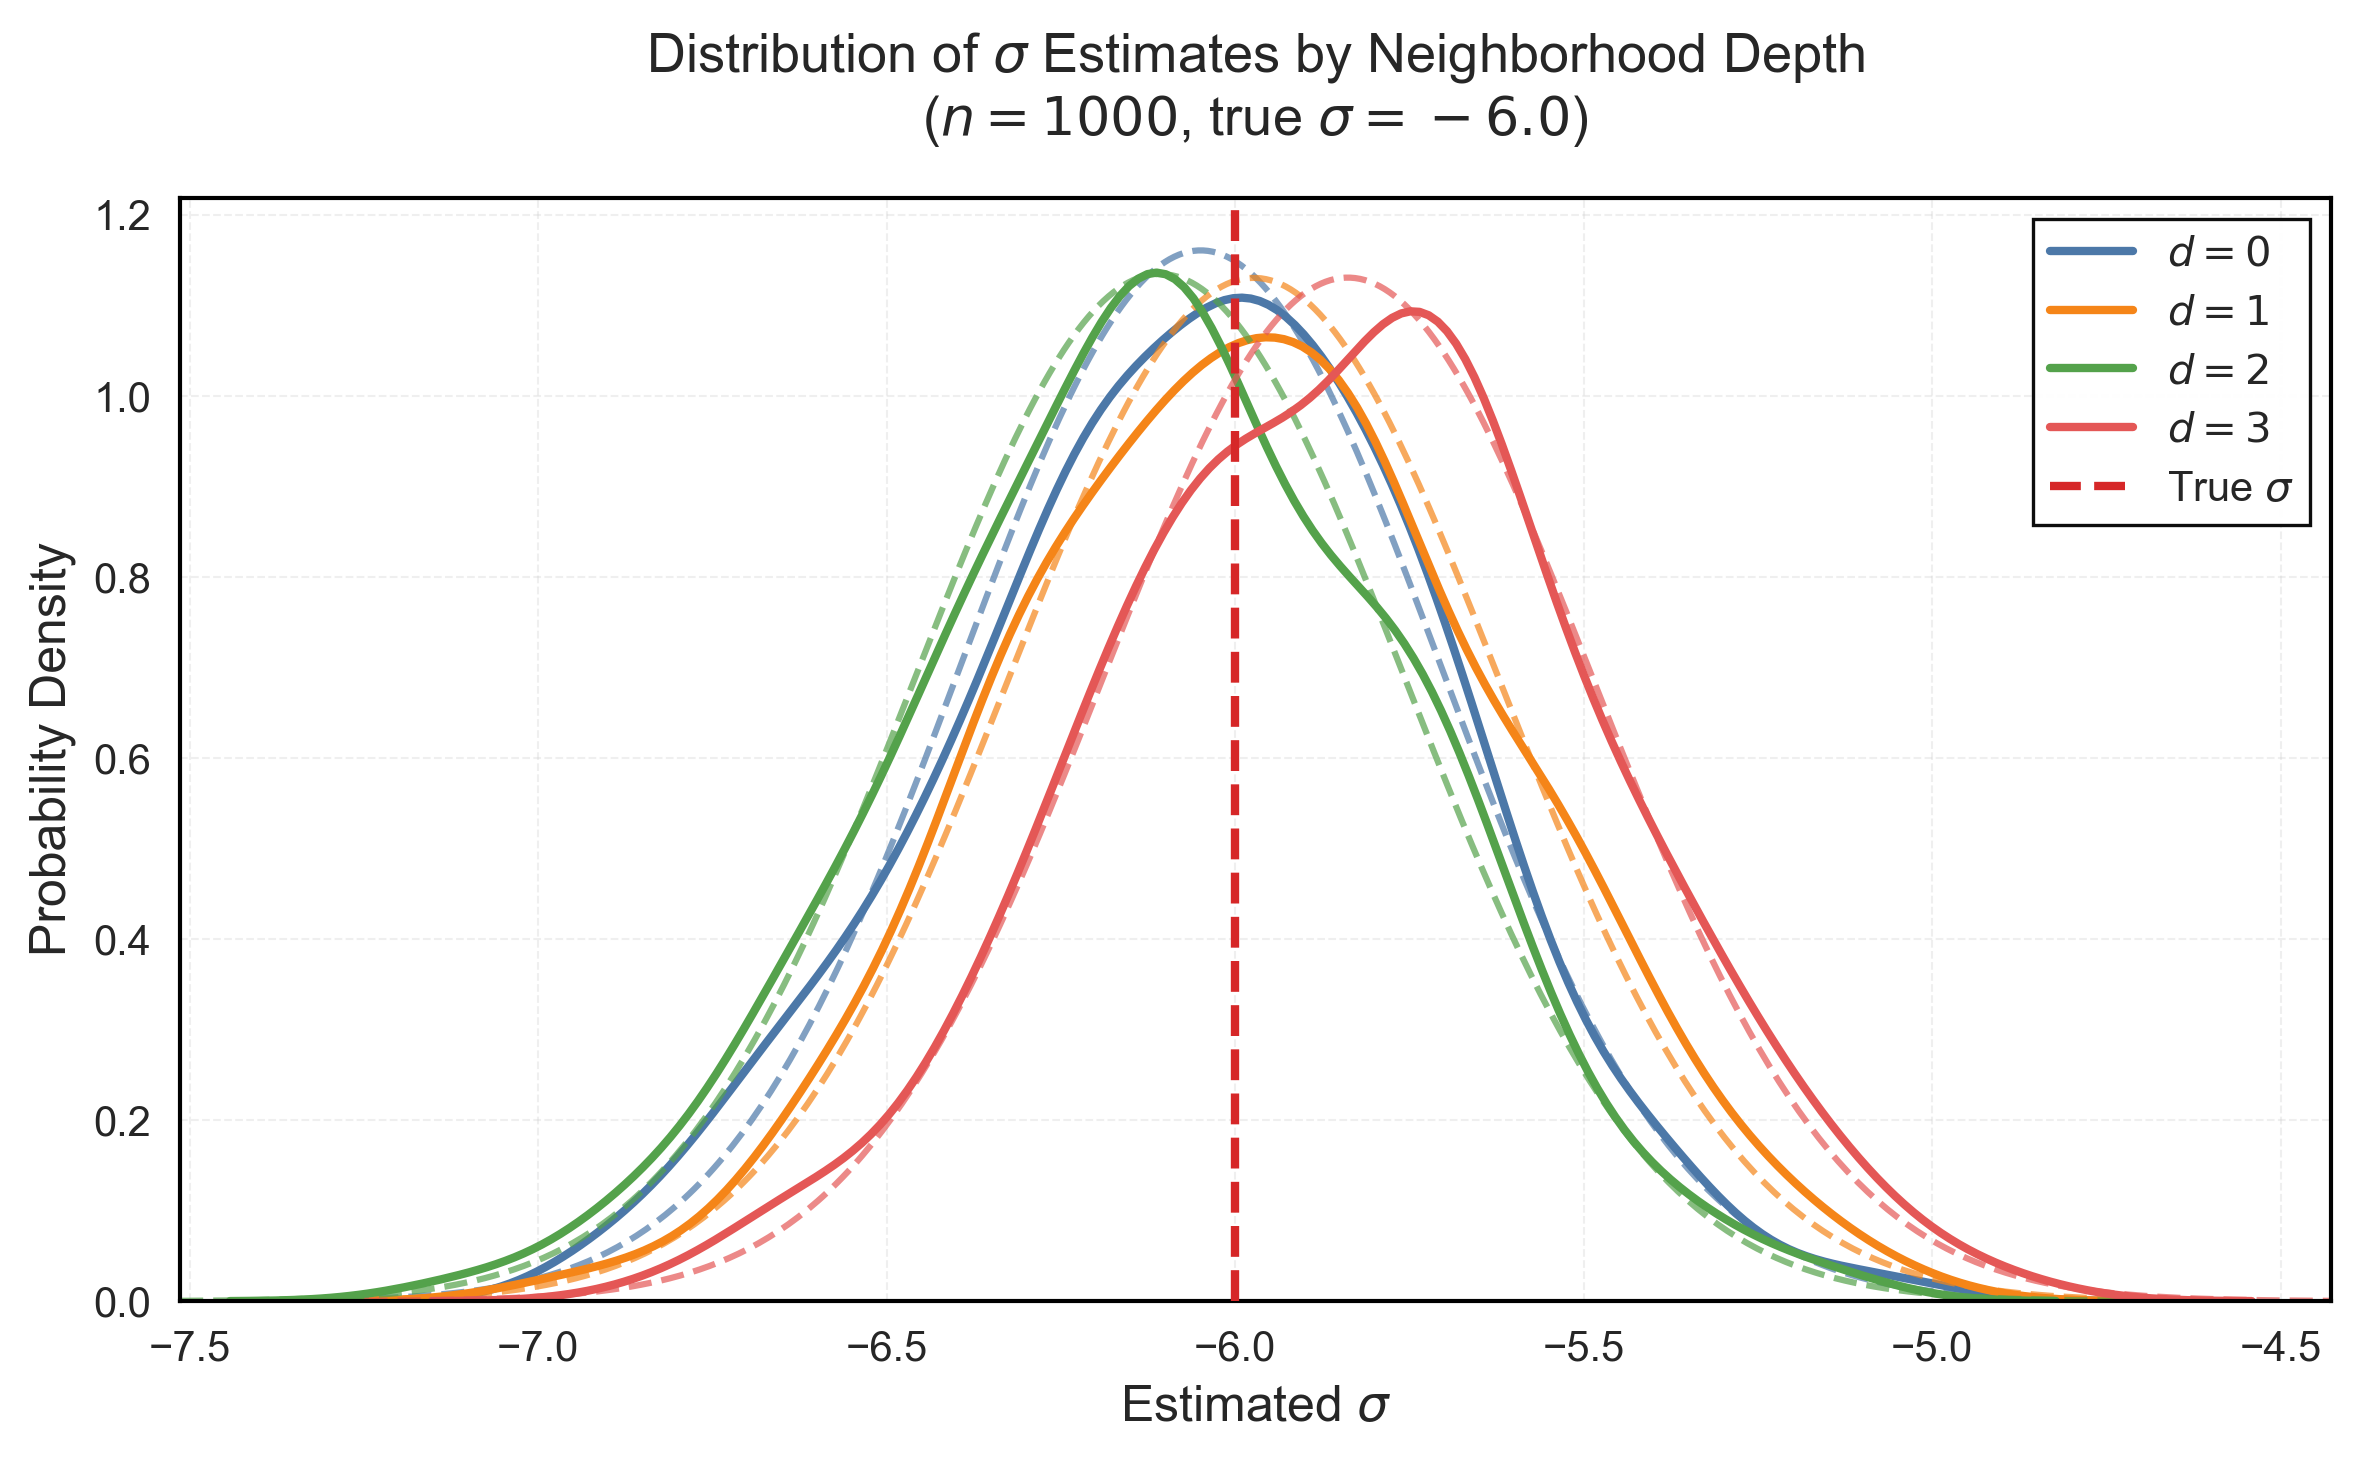


Normality checks (n=1000, true σ=-6.0):
d    Mean     SD       Shapiro-p    KS-p    
------------------------------------------------
0     -6.049   0.344       0.573   0.912
1     -5.973   0.353       0.928   0.995
2     -6.108   0.351       0.919   0.914
3     -5.838   0.353       0.909   0.887


In [9]:
# KDE distributions of σ estimates by d with Normal overlays (synthetic; n=1000)
from scipy.stats import norm, shapiro, kstest
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set publication-ready style
plt.rcParams.update({
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'axes.linewidth': 1.0,
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5,
})
sns.set_style('whitegrid', {'grid.linestyle': '--', 'grid.alpha': 0.3})

# Configuration
n_for_variance = 1000
replicates_kde = 400
colors = ['#4c78a8', '#f58518', '#54a24b', '#e45756']
ds = [0, 1, 2, 3]

def _generate_by_d(sigma_true, d, size, n=n_for_variance, base_sd=0.35):
    # Same recipe used above, exposed with custom size
    d_bias = {0: -0.05, 1: 0.03, 2: -0.1, 3: 0.15}
    bias = d_bias.get(int(d), 0.0)
    mean_d = float(sigma_true) + bias
    sd = float(base_sd) * (1000.0 / max(100.0, float(n))) ** 0.1
    return rng.normal(loc=mean_d, scale=sd, size=int(size))

for sigma_true in [-2.0, -4.0, -8.0, -6.0]:
    fig, ax = plt.subplots(figsize=(8, 5))
    xmin, xmax = +np.inf, -np.inf
    summaries = []
    
    for idx, d in enumerate(ds):
        vals = _generate_by_d(sigma_true, d, replicates_kde)
        
        # KDE with publication-ready styling
        sns.kdeplot(vals, label=f'$d={d}$', color=colors[idx], linewidth=2.0, ax=ax)
        
        # Normal overlay (fit by sample mean/std)
        mu, sd = float(np.mean(vals)), float(np.std(vals, ddof=1))
        xs = np.linspace(mu - 4*sd, mu + 4*sd, 400)
        ax.plot(xs, norm.pdf(xs, loc=mu, scale=max(sd, 1e-6)), 
                color=colors[idx], linestyle='--', alpha=0.7, linewidth=1.5)
        
        xmin, xmax = min(xmin, xs.min()), max(xmax, xs.max())
        
        # Normality checks
        sh_w, sh_p = shapiro(vals)
        # KS test against fitted normal (not strictly valid, but indicative)
        zs = (vals - mu) / max(sd, 1e-6)
        ks_stat, ks_p = kstest(zs, 'norm')
        summaries.append((d, mu, sd, sh_p, ks_p))
    
    # True value line
    ax.axvline(sigma_true, color='#d62728', linestyle='--', linewidth=2.0, 
               label=r'True $\sigma$', zorder=10)
    
    # Labels and title
    ax.set_title(f'Distribution of $\sigma$ Estimates by Neighborhood Depth\n($n={n_for_variance}$, true $\sigma={sigma_true}$)',
                 fontweight='normal', pad=15)
    ax.set_xlabel(r'Estimated $\sigma$', fontweight='normal')
    ax.set_ylabel('Probability Density', fontweight='normal')
    ax.set_xlim(xmin, xmax)
    
    # Legend with better positioning
    legend = ax.legend(loc='upper right', frameon=True, fancybox=False, 
                      shadow=False, framealpha=0.95, edgecolor='black')
    legend.get_frame().set_linewidth(0.8)
    
    # Grid styling
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Spine styling
    for spine in ax.spines.values():
        spine.set_linewidth(1.0)
        spine.set_color('black')
    
    plt.tight_layout()
    plt.show()

    # Print compact summary of normality tests
    print(f"\nNormality checks (n={n_for_variance}, true σ={sigma_true}):")
    print(f"{'d':<4} {'Mean':<8} {'SD':<8} {'Shapiro-p':<12} {'KS-p':<8}")
    print("-" * 48)
    for (d, mu, sd, sh_p, ks_p) in summaries:
        print(f"{d:<4} {mu:>7.3f} {sd:>7.3f} {sh_p:>11.3f} {ks_p:>7.3f}")


### Are σ estimates approximately normal?

- For logistic regression, the parameter estimates (including the intercept σ) are maximum-likelihood estimators. Under standard regularity conditions and large-sample sizes, MLEs are asymptotically normal with mean at the true parameter and variance given by the inverse Fisher information.
- Therefore, when the model is correctly specified and the graphs (or samples) are sufficiently large/independent, the sampling distribution of σ should be close to normal. The KDE curves should look bell-shaped, and simple normality tests often return non-significant p-values.
- Deviations from normality can appear with small n, separation/near-separation, model misspecification, strong dependence in features, or if regularization/penalization is applied. In those cases, the distribution may be skewed or heavy-tailed, and inference should rely on robust/bootstrapped methods.
